### Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [18]:
%cd /gdrive/My Drive/polimi/artificialneuraldeep/ex5

/gdrive/My Drive/polimi/artificialneuraldeep/ex5


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
import scipy.io as sio

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [19]:
ls -l

total 64447
-rw------- 1 root root  1145743 Dec 17 12:50 '5) Autoencoder.ipynb'
-rw------- 1 root root   600294 Dec 17 13:08 '5) Multiclass_Segmentation.ipynb'
drwx------ 2 root root     4096 Dec 17 12:17  autoencoder/
drwx------ 2 root root     4096 Dec 17 12:17  ClothingDataset/
-rw------- 1 root root 64045740 Dec 17 11:08  ClothingDataset.zip
-rw------- 1 root root   188040 Dec 17 11:08  model.png
drwx------ 2 root root     4096 Dec 17 12:17  SegmentationModel/


# Clothing Segmentation Dataset

https://github.com/bearpaw/clothing-co-parsing

RGB images containing objects belonging to 59 different classes. 
Targets are masks that assign each pixel to the class of the object it belongs.

Classes:
 
 'null' 'accessories' 'bag' 'belt' 'blazer' 'blouse' 'bodysuit' 'boots'
 'bra' 'bracelet' 'cape' 'cardigan' 'clogs' 'coat' 'dress' 'earrings'
 'flats' 'glasses' 'gloves' 'hair' 'hat' 'heels' 'hoodie' 'intimate'
 'jacket' 'jeans' 'jumper' 'leggings' 'loafers' 'necklace' 'panties'
 'pants' 'pumps' 'purse' 'ring' 'romper' 'sandals' 'scarf' 'shirt' 'shoes'
 'shorts' 'skin' 'skirt' 'sneakers' 'socks' 'stockings' 'suit'
 'sunglasses' 'sweater' 'sweatshirt' 'swimwear' 't-shirt' 'tie' 'tights'
 'top' 'vest' 'wallet' 'watch' 'wedges'

In [20]:
# Unzip the dataset 
!unzip ClothingDataset.zip

Archive:  ClothingDataset.zip
replace ClothingDataset/Annotations/0001.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ClothingDataset/Annotations/0001.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ClothingDataset/Annotations/0001.mat  
  inflating: ClothingDataset/Annotations/0002.mat  
  inflating: ClothingDataset/Annotations/0003.mat  
  inflating: ClothingDataset/Annotations/0004.mat  
  inflating: ClothingDataset/Annotations/0005.mat  
  inflating: ClothingDataset/Annotations/0006.mat  
  inflating: ClothingDataset/Annotations/0007.mat  
  inflating: ClothingDataset/Annotations/0008.mat  
  inflating: ClothingDataset/Annotations/0009.mat  
  inflating: ClothingDataset/Annotations/0010.mat  
  inflating: ClothingDataset/Annotations/0011.mat  
  inflating: ClothingDataset/Annotations/0012.mat  
  inflating: ClothingDataset/Annotations/0013.mat  
  inflating: ClothingDataset/Annotations/0014.mat  
  inflating: ClothingDataset/Annotations/

In [21]:
# Folder structure
!ls ClothingDataset
print()

Annotations  Images  label_list.npy



In [22]:
# Set dataset dir
dataset_dir = 'ClothingDataset'

In [23]:
# Get all (pixel-level) labels in the dataset
labels = np.load(os.path.join(dataset_dir, 'label_list.npy'))
print("Found {} labels:".format(len(labels)))
print(labels)

Found 59 labels:
['null' 'accessories' 'bag' 'belt' 'blazer' 'blouse' 'bodysuit' 'boots'
 'bra' 'bracelet' 'cape' 'cardigan' 'clogs' 'coat' 'dress' 'earrings'
 'flats' 'glasses' 'gloves' 'hair' 'hat' 'heels' 'hoodie' 'intimate'
 'jacket' 'jeans' 'jumper' 'leggings' 'loafers' 'necklace' 'panties'
 'pants' 'pumps' 'purse' 'ring' 'romper' 'sandals' 'scarf' 'shirt' 'shoes'
 'shorts' 'skin' 'skirt' 'sneakers' 'socks' 'stockings' 'suit'
 'sunglasses' 'sweater' 'sweatshirt' 'swimwear' 't-shirt' 'tie' 'tights'
 'top' 'vest' 'wallet' 'watch' 'wedges']


In [10]:
# Simplify the dataset
# Recognize 'null', 'skin', 'hair', 'clothing' -> 'clothing' comprises all the other categories

# old 'null' label
old_null_label = 0
# old 'hair' label
old_hair_label = 19
# old 'skin' label
old_skin_label = 41
# old 'clothing' labels
old_clothing_labels = [l for l in range(59) if (l != 0 and l != 19 and l != 41)]

new_labels = {0: 'null', 1: 'clothing', 2: 'hair', 3: 'skin'}
 
# We need also a way to convert old labels (with missing values) to new ones.
# Create a dictionary (orig2new) that will be used to convert old labels to new labels,
# and a dictionary (new2orig) that allows to come back to the old labelling.
orig2new = {l:1 for l in range(59)} # init to 'clothing'
orig2new[old_null_label] = 0
orig2new[old_hair_label] = 2
orig2new[old_skin_label] = 3

print(orig2new)

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 2, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 3, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1}


In [11]:
# Generate n different colors (one for each label)
def get_cmap(n, name='rainbow'):
    # Get N colors from 'rainbow' colorspace
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(4) # 4 is the number of classes
colors = []
for i in range(1, 4): # except the background class ('null')
  color = np.array(mpl.colors.to_rgb(cmap(i)))
  colors.append(list(color))

np.random.shuffle(colors)
colors = [[0, 0, 0]] + colors # the first color "black" is assigned to the class 0

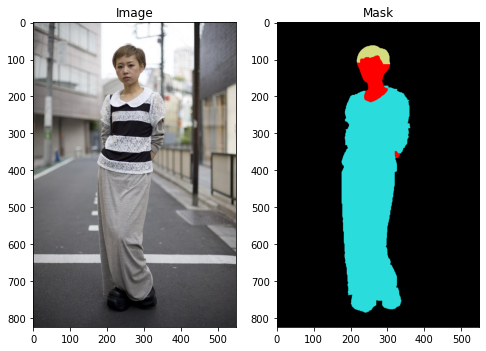

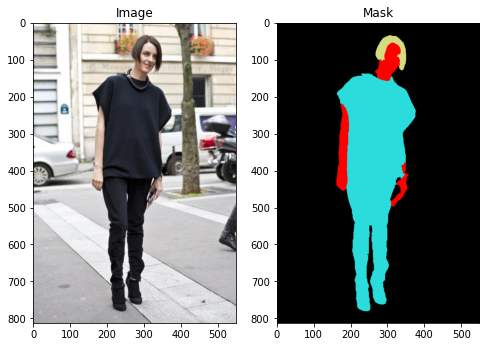

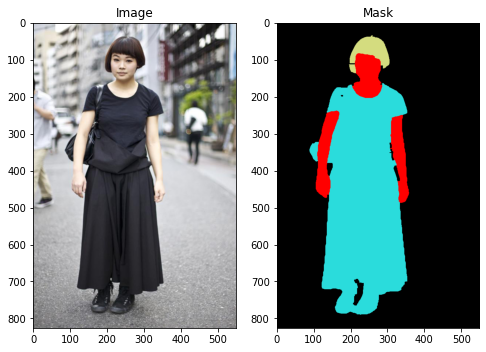

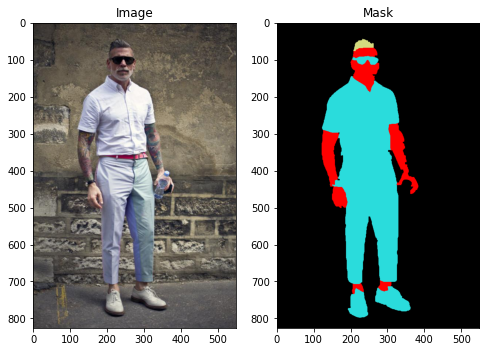

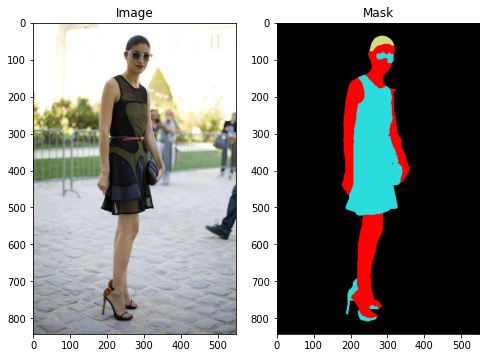

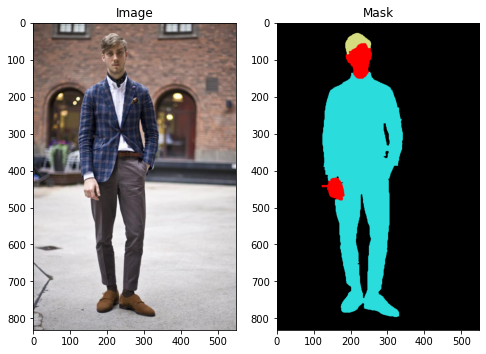

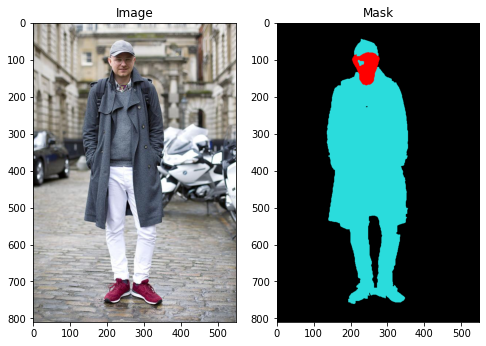

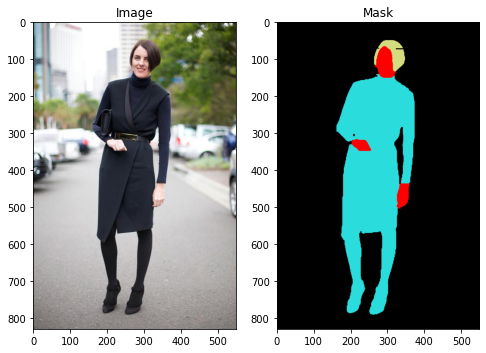

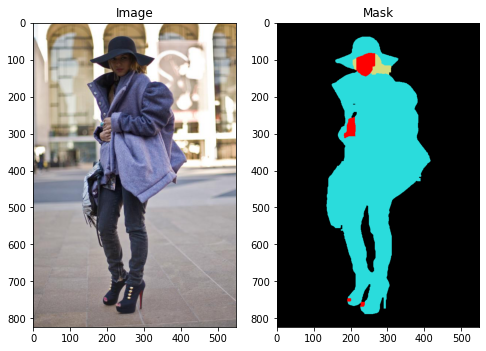

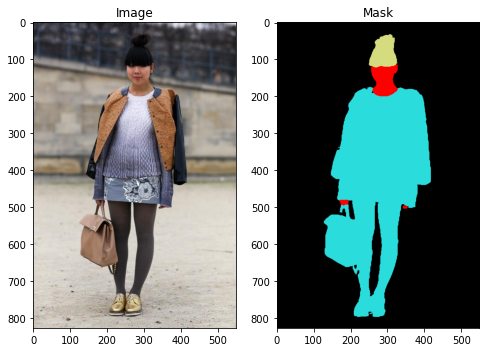

In [24]:
# Visualize some examples (10)
# Read all filenames in the directory Images (jpg files)
image_fnames = next(os.walk(os.path.join(dataset_dir, 'Images')))[2]
for i in range(10):
  image_fname = image_fnames[i]
  mask_fname = image_fname[:-3] + 'mat'  # masks are saved as '.mat' file that can be read with scipy
  
  # Read jpg RGB image with Image (PIL)
  image = np.array(Image.open(os.path.join(dataset_dir, 'Images', image_fname)))
  # Read mat mask with scipy (scipy.io.loadmat)
  mask_dict = sio.loadmat(os.path.join(dataset_dir, 'Annotations', mask_fname))
  mask = mask_dict['groundtruth']  # The result is a dictionary, the content is under the key 'groundtruth'
  
  # Assign colors we have created before (just for visualization)
  # Create an empty 'mask_rgb' array filled with zeros
  mask_rgb = np.zeros([mask.shape[0], mask.shape[1], 3])
  # For each class in the mask, assign the corresponding color (colors[i])
  for i in range(59):
    color_idx = orig2new[i]
    mask_rgb[np.where(mask == i)] = np.array(colors[color_idx])[:3]

  # Plot
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))
  ax[0].imshow(image)
  ax[1].imshow(mask_rgb)
  ax[0].set_title('Image')
  ax[1].set_title('Mask')
  plt.show()

Objects in the image:
[ 0  5 19 39 41 42 45 47 55]


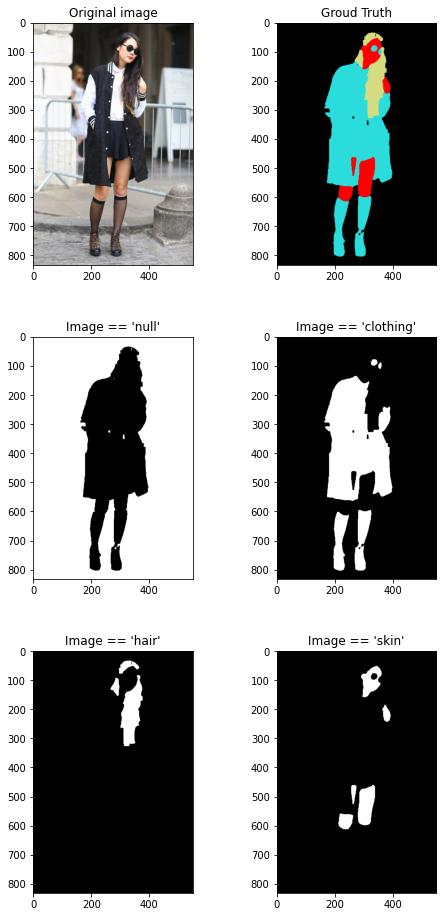

In [25]:
# Given an image, plot all the classes separately
# e.g., image_fname = '0001.jpg'
image_fname = '0001.jpg'
mask_fname = '0001.mat'

image = Image.open(os.path.join(dataset_dir, 'Images', image_fname))
mask_dict = sio.loadmat(os.path.join(dataset_dir, 'Annotations', mask_fname))
mask = mask_dict['groundtruth']

mask_rgb = np.zeros([mask.shape[0], mask.shape[1], 3])
for i in range(59):
  color_idx = orig2new[i]
  mask_rgb[np.where(mask == i)] = np.array(colors[color_idx])[:3]

# Get all objects (labels) in the mask with 'np.unique'
image_objects = np.unique(mask)
print("Objects in the image:")
print(image_objects)

# Plot the original RGB image, the GT segmentation, and all the classes (as binary images)
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(8, 16))
ax[0][0].set_title("Original image")
ax[0][0].imshow(image)
ax[0][1].set_title("Groud Truth")
ax[0][1].imshow(mask_rgb)
ax[1][0].set_title("Image == 'null'")
ax[1][0].imshow(np.uint8(mask == old_null_label), cmap='gray')  # Get mask is 'null'
ax[1][1].set_title("Image == 'clothing'")
ax[1][1].imshow(
    np.uint8(mask != old_null_label) * 
    np.uint8(mask != old_hair_label) * 
    np.uint8(mask != old_skin_label), cmap='gray') # Get mask is 'clothing'
ax[2][0].set_title("Image == 'hair'")
ax[2][0].imshow(np.uint8(mask == old_hair_label), cmap='gray') # Get mask == 'hair'
ax[2][1].set_title("Image == 'skin'")
ax[2][1].imshow(np.uint8(mask == old_skin_label), cmap='gray') # Get mask == 'skin'

fig.subplots_adjust(hspace=.3)

# Data Loading
## Custom Generator

In [26]:
# Import the data generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [27]:
# Just as exercise, try to load a mask and to apply a random transformation.
mask_dict = sio.loadmat(os.path.join(dataset_dir, 'Annotations', mask_fname))
mask = mask_dict['groundtruth']
# Get object classes in the mask before the augmentation
print("Unique mask values before the augmentation")
print(np.unique(mask))

# Suppose that we want to apply data augmentation to the mask.
# e.g., rotation
rot_gen = ImageDataGenerator(rotation_range=30)
rot_t = rot_gen.get_random_transform(img_shape=mask.size)
rotated = rot_gen.apply_transform(np.array(mask)[..., None], rot_t)

# Check at the end of the augmentation the values in the mask
print()
print("Unique mask values after the augmentation")
print(np.unique(rotated))

print()
print("Ground Truth values have been interpolated!")

# Due to the interpolation, the mask will contain values that do not correspond
# to any object in the image. Let's try another approach to load data.

Unique mask values before the augmentation
[ 0  5 19 39 41 42 45 47 55]

Unique mask values after the augmentation
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55]

Ground Truth values have been interpolated!


In [28]:
# In the following A POSSIBLE implementation
class CustomGenerator(tf.keras.utils.Sequence):
  """
    CustomGenerator inheriting from tf.keras.utils.Sequence.

    We have to implement 3 main methods:
      - __init__: save dataset params like directory, filenames, etc.
      - __len__: return the total number of samples in the dataset (number of batches)
      - __getitem__: return a single batch of paired images masks

    Note: 
      - In this case we have a different structure of the dataset in memory since
        there are no sub-folders for the classes, but all the images/masks are in 
        a single folder.

  """

  def __init__(self, 
               dataset_dir, # directory of the dataset  
               which_subset, # which subset, string in ['training', 'validation']
               validation_split=0.1, # percentage of images used for validation
               img_generator=None,  # ImageDataGenerator for RGB images
               mask_generator=None, # ImageDataGenerator for masks
               label_cleaner=None,  # Dictionary to map original labels to new ones
               preprocessing_function=None, # Preprocessing function (e.g., the one used for transfer learning)
               out_shape=None, # If not None, resize the images to out_shape 
               crop_size=None, # If not None and which_subset = 'training', perform random cropping with size 'crop_size'
               batch_size=8, # Batch size
               shuffle=False): # Whether to shuffle the images at each epoch
    
    # Get all filenames in the 'Images' folder
    filenames = next(os.walk(os.path.join(dataset_dir, 'Images')))[2]

    # Random split in training and validation
    np.random.shuffle(filenames)
    num_valid_samples = int(len(filenames)*validation_split)
    train_subset = filenames[:-num_valid_samples]
    valid_subset = filenames[-num_valid_samples:]

    # Select which subset to load
    if which_subset == 'training':
      subset_filenames = train_subset
    elif which_subset == 'validation':
      subset_filenames = valid_subset 

    print("Found {} images in the {} subset".format(len(subset_filenames), which_subset))

    # Set indices list in [0, len(subset_filenames)]
    self.indices = np.arange(len(subset_filenames))

    # Save dataset parameters as class attributes
    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.label_cleaner = label_cleaner
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape
    self.crop_size = crop_size
    self.batch_size = batch_size
    self.shuffle = shuffle

  def __len__(self):
    # Return the length of the dataset (number of batches)
    # that is given by #images // batch_size
    return len(self.subset_filenames) // self.batch_size

  def on_epoch_start(self):
    # Shuffle indices after each epoch
    if self.shuffle == True:
        np.random.shuffle(self.indices)

  def random_crop(self, image, mask, crop_size):
    # Get a random crop from the image/mask
    is_all_zero = True
    if crop_size[0] == image.shape[0] and crop_size[1] == image.shape[1]:
      return image, mask

    height, width = image.shape[:2]
    
    # Search a crop that contains enough objects (e.g., at least 20% of the pixels)
    # This is done to alleviate the problem of class unbalancing (per-pixel),
    # e.g., the background cover a large portion in each image.
    is_ok = False # It will be True when a good crop is found
    acceptable_portion = 80 * crop_size[0] * crop_size[1] # max 80% of pixels can be background
    attempts_counter = 0 # The procedure to search a good crop can run for a long time. Set a counter to limit the iterations.
    while not is_ok:
      attempts_counter += 1
      if attempts_counter == 10: 
        is_ok = True # Label the crop as "good" anyway if we reach the maximum number of iterations

      rnd_h = np.random.randint(height-crop_size[0])
      rnd_w = np.random.randint(width-crop_size[1])

      image_crop = image[rnd_h:rnd_h+crop_size[0], rnd_w:rnd_w+crop_size[1], :3]
      mask_crop = mask[rnd_h:rnd_h+crop_size[0], rnd_w:rnd_w+crop_size[1]]

      if np.sum(mask_crop == 0) <= acceptable_portion:
        is_ok = True
    return image_crop, mask_crop

  def crop_center(self, image, mask, crop_size):
    # Perform a fixed crop of size crop_size at the center of the image/mask
    h, w = image.shape[:2]
    start_h = (h // 2) - (crop_size[0] // 2)
    start_w = (w // 2) - (crop_size[1] // 2)    
    image = image[start_h:start_h+crop_size[0],start_w:start_w+crop_size[1], :]
    mask = mask[start_h:start_h+crop_size[0],start_w:start_w+crop_size[1], :]
    return image, mask

  def get_image_and_mask(self, index):
    # This function allows to read the single image and corresponding mask at index 'index' 
    curr_filename = self.subset_filenames[index] # Get jpg filename at index
    mask_fname = curr_filename[:-3] + 'mat' # Get mask filename by substituting 'jpg' with 'mat'

    # Read image (with PIL) and mask (with scipy)
    image = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename))
    mask_dict = sio.loadmat(os.path.join(dataset_dir, 'Annotations', mask_fname))
    mask = mask_dict['groundtruth']
    mask = Image.fromarray(mask)

    # If 'out_shape' is not None resize both the image and mask to the desired shape
    if self.out_shape is not None:
      image = image.resize(self.out_shape, resample=Image.BILINEAR)
      mask = mask.resize(self.out_shape, resample=Image.NEAREST) # NEAREST to avoid interpolation of labels
    
    # Convert 'Image' objects to arrays
    image = np.array(image)
    mask = np.array(mask)

    # If 'crop_size' is not None get a random crop from image/mask
    if self.crop_size is not None:
      image, mask = self.random_crop(image, mask, self.crop_size)
    
    # Add channel dimension to mask
    mask = np.expand_dims(mask, -1)

    return image, mask

  def __getitem__(self, index):
    # In this function we generate a batch (of size self.batch_size) of images and corresponding masks
    
    # Get 'self.batch_size' indices
    current_indices = self.indices[index*self.batch_size:(index*self.batch_size)+self.batch_size]

    # Init lists that will contain images and masks
    batch_images = []
    batch_masks = []

    # Cycle over the indices
    for idx in current_indices:
      # Get single image/mask at index 'idx'
      image, mask = self.get_image_and_mask(idx)

      # Here we differentiate the 'training' from the 'validation'
      # since during training we can perform data augmentation
      if self.which_subset == 'training':
        if self.img_generator is not None and self.mask_generator is not None:
          # Perform data augmentation
          # -------------------------

          # Get random transformation from the ImageDataGenerator
          image_t = self.img_generator.get_random_transform(image.shape)

          # Apply the obtained transformation to the RGB image
          image = self.img_generator.apply_transform(image, image_t)

          # ImageDataGenerator use bilinear interpolation for augmenting the images.
          # Thus, when applied to the masks it will output 'interpolated classes', which
          # is an unwanted behaviour. As a trick, we can transform each class mask 
          # separately and then we can cast to integer values.
          # Finally, we merge the augmented binary masks to obtain the final segmentation mask.

          # Create a mask of zeros which will contain the augmented mask
          out_mask = np.zeros_like(mask)
          
          # Get object classes in the image
          object_classes = np.unique(mask)
          # Cycle over classes  
          for c_idx, c in enumerate(object_classes):
            if c > 0:
              # Get binary image (1 if mask == c, 0 otherwise)
              curr_class_mask = np.float32(mask == c)
              # Apply the transformation (the same applied to the RGB image) to the current class mask
              curr_class_mask = self.mask_generator.apply_transform(curr_class_mask, image_t)
              # Convert from continuous in [0, 1] to binary {0, 1} (by casting to uint8)
              curr_class_mask = np.uint8(curr_class_mask)
              # Recover original class from binary mask by multiplying by original 'c'
              curr_class_mask = curr_class_mask * c 
              out_mask += curr_class_mask # Sum the current mask to the final mask
      else:
        out_mask = mask
      
      if self.which_subset == 'validation':
        # During validation we use the original images (no crop)
        # but images can have different shapes, which could not fit the 
        # downsampling scale of the network.  
        # A possible solution is to pad or to crop the input. 
        # Here we get the highest center crop.

        # Downsampling scale factor (!for the used network, i.e., VGG)
        scale_factor = 32

        # Highest possible crop divisible by the scale_factor
        new_image_h = (image.shape[0] // scale_factor) * scale_factor
        new_image_w = (image.shape[1] // scale_factor) * scale_factor
        image, out_mask = self.crop_center(image, out_mask, [new_image_h, new_image_w])
        
      # Apply the preprocessing function
      if self.preprocessing_function is not None:
        image = self.preprocessing_function(image)

      # If a 'label cleaner' is provided apply it
      if self.label_cleaner:
        # This will convert all the original labels (with missing values) to the new ones
        for c in np.unique(out_mask):
          out_mask[out_mask == c] = self.label_cleaner[c]

      # Append both image and mask (with added batch dimension) to the corresponding batch lists
      batch_images.append(np.expand_dims(image, 0))
      batch_masks.append(np.expand_dims(out_mask, 0))
     
    # Finally, obtain a final batch by concatenating all the images/masks over the batch dimension
    batch_images = np.concatenate(batch_images, axis=0)
    batch_masks = np.concatenate(batch_masks, axis=0)

    return batch_images, np.float32(batch_masks)

In [29]:
# ImageDataGenerator
# ------------------
apply_data_augmentation = True

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
  aug_image_gen = ImageDataGenerator(rotation_range=10,
                                     height_shift_range=10,
                                     width_shift_range=10,
                                    #  zoom_range=0.3,
                                     horizontal_flip=True,
                                     # vertical_flip=True, 
                                     fill_mode='reflect',
                                     rescale=1/255.) # rescale value is multiplied to the image
  aug_mask_gen = ImageDataGenerator(rotation_range=10,
                                    height_shift_range=10,
                                    width_shift_range=10,
                                    # zoom_range=0.3,
                                    horizontal_flip=True,
                                    # vertical_flip=True, 
                                    fill_mode='reflect',
                                    rescale=1)
  
valid_image_gen = ImageDataGenerator(rescale=1/255.)
valid_mask_gen = ImageDataGenerator(rescale=1)

In [30]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Dimensions of the random crop in training
img_h = img_w = 128

# Create CustomGenerator for training
train_gen = CustomGenerator('ClothingDataset', 'training', batch_size=64,
                          img_generator=aug_image_gen, mask_generator=aug_mask_gen, 
                          label_cleaner=orig2new, # preprocessing_function=preprocess_input,
                          crop_size=[img_h, img_w], shuffle=True)
# Create CustomGenerator for validation
valid_gen = CustomGenerator('ClothingDataset', 'validation', batch_size=1,
                            img_generator=valid_image_gen, mask_generator=valid_mask_gen,
                            label_cleaner=orig2new, # preprocessing_function=preprocess_input, 
                            shuffle=False)

Found 904 images in the training subset
Found 100 images in the validation subset


In [31]:
# Let's test data generator
# -------------------------
iterator = iter(train_gen)

4085
4437
4608
4956
Objects in the image:
[0. 1. 3.]


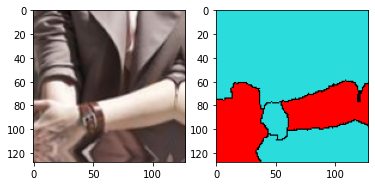

In [32]:
# Plot one sample from the current batch
fig, ax = plt.subplots(1, 2)

# Get next batch from the dataset
augmented_img, target = next(iterator)


print(np.sum(augmented_img == 0))
print(np.sum(augmented_img == 1))
print(np.sum(augmented_img == 2))
print(np.sum(augmented_img == 3))

augmented_img = augmented_img[0]     # It is a batch of 64 images, get the first
target = np.array(target[0, ..., 0]) # Get also first mask (squeezing channel dimension)

print("Objects in the image:")
print(np.unique(target))

# Colorize the target assigning each pixel in the mask the corresponding color
target_img = np.zeros([target.shape[0], target.shape[1], 3])
for i in range(4):
  target_img[np.where(target == i)] = np.array(colors[i])[:3] * 255

# Plot
ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target_img))

plt.show()

## Encoder-Decoder CNN

In [33]:
# Import VGG (No transfer learning)
vgg = tf.keras.applications.VGG16(weights=None, include_top=False, input_shape=(None, None, 3))
vgg.summary()
# Set all VGG layers to True
vgg.trainable = True
# Freeze first N layers, e.g., until 14th
for i, layer in enumerate(vgg.layers):
  layer.trainable=True
for i, layer in enumerate(vgg.layers):
   print(i, layer.name, layer.trainable)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [34]:
# Function to create the model 
# Architecture: Encoder-Decoder (similar to Autoencoders)
# Encoder VGG -> Decoder (Conv + Bilinear Upsampling) + Segmentation Layer (1x1 Conv + Softmax)
def create_model_unet_style(depth, num_classes):
    
    input_layer = tfkl.Input(shape=[None, None, 3])

    skip_layers = []

    # Encoder
    # -------
    x = input_layer
    for i, layer in enumerate(vgg.layers):
      if 'pool' in layer.name:
        skip_layers.append(x)
      x = layer(x)
    
    start_f = 256
        
    # Decoder
    # -------
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        x = tfkl.Concatenate(axis=-1)([x, skip_layers[-(i+1)]])

        x = tfkl.Conv2D(filters=start_f,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding='same')(x)
        x = tfkl.ReLU()(x)

        start_f = start_f // 2

    # Segmentation Layer
    # ----------------
    # Conv 1x1, number of filters = number of classes, activation = softmax
    x = tfkl.Conv2D(filters=num_classes,
                    kernel_size=(1, 1),
                    strides=(1, 1),
                    padding='same',
                    activation='softmax')(x)

    model = tfk.Model(inputs=input_layer, outputs=x)
    
    # Here we define the intersection over union for each class in the batch.
    # Then we compute the final iou as the mean over classes
    def meanIoU(y_true, y_pred):
      # y_true shape: [BS, H, W, 1] -> directly the integer label
      # y_pred shape: [BS, H, W, C] -> where C is the number of classes

      # Get predicted class from the output softmax (for each pixel)
      # by computing the argmax over the last (channel) dimension
      y_pred = tf.argmax(y_pred, -1)
      y_pred = tf.expand_dims(y_pred, -1) # Add 1 channel dimension

      # Lists to save IoU and Union for each class
      per_class_iou = []
      per_class_union = []

      # Cycle over classes [1-4], excluding the background class 0
      for i in range(1,4):
        # Get prediction and target related to only a single class (i)
        # Binary prediction mask -> 1 if pred == i, 0 otherwise
        class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
        # Binary target mask -> 1 if pred == i, 0 otherwise
        class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)

        # Pred & GT
        intersection = tf.reduce_sum(class_true * class_pred)
        # Pred | GT
        union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection

        iou = intersection / (union + 1e-7)

        per_class_union.append(union)
        per_class_iou.append(iou)

      per_class_iou = tf.stack(per_class_iou, axis=0)
      per_class_union = tf.stack(per_class_union, axis=0)
      
      # If the union is 0 it means that the corresponding class is not in the current batch
      # (it has not been neither prediction nor in the GT)
      non_zero = tf.cast(per_class_union > 0, tf.float32)
      # Number of classes in the batch
      batch_classes = tf.reduce_sum(non_zero)
      
      # Return the mean IoU given by the sum of per-class IoU divided by the number of batch classes
      return tf.reduce_sum(per_class_iou) / batch_classes

    # Compile the model
    model.compile(loss=tfk.losses.SparseCategoricalCrossentropy(),
                  optimizer=tfk.optimizers.Adam(learning_rate=1e-3), metrics=[meanIoU])

    return model

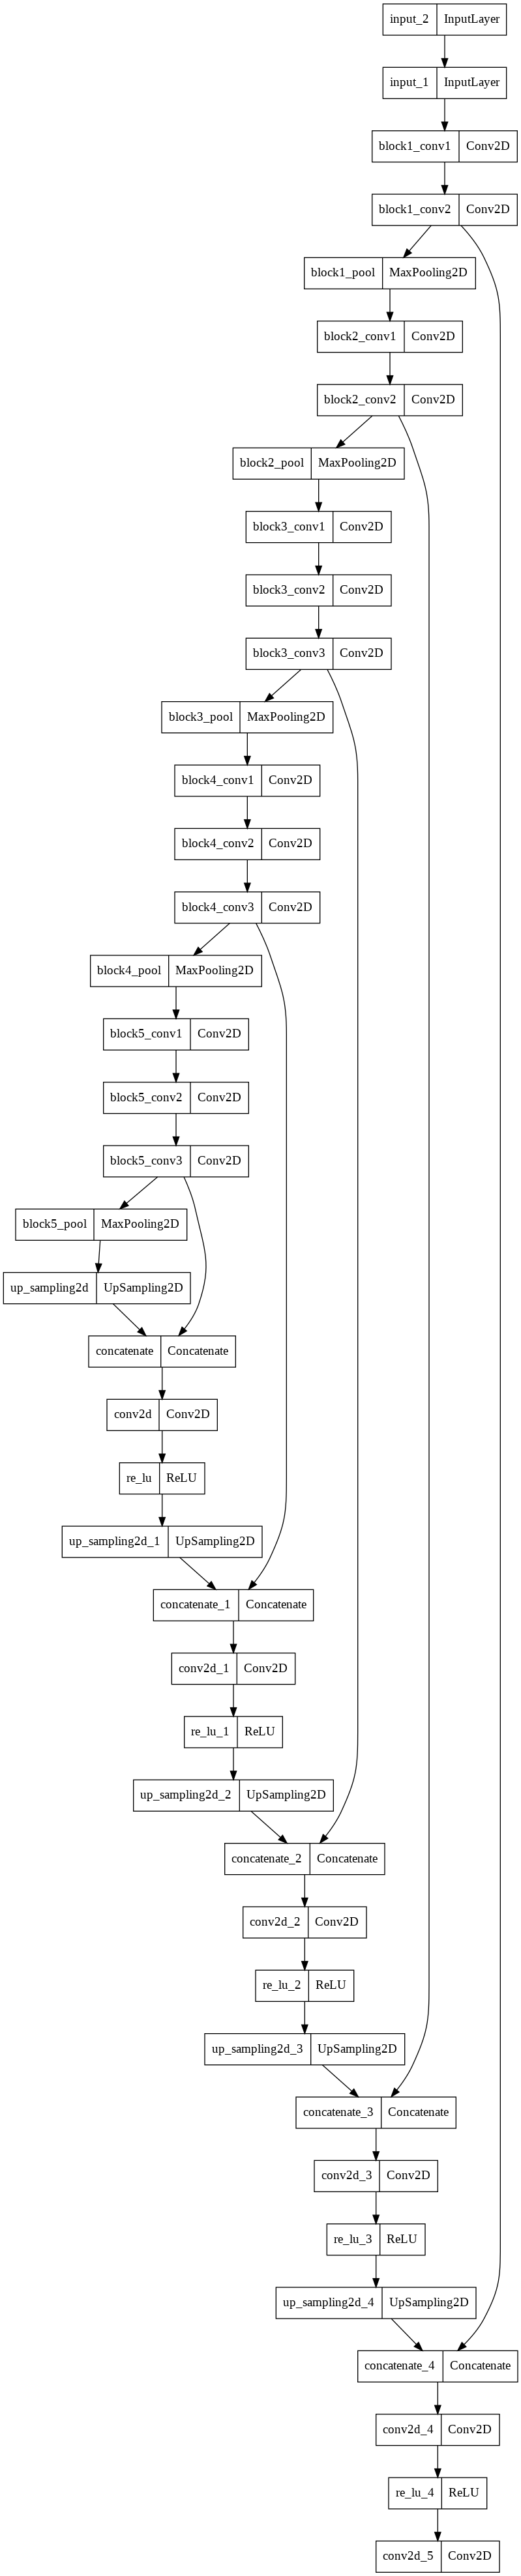

In [35]:
# Create the model
model = create_model_unet_style(depth=5, num_classes=4)

# Visualize created model as a table
# model.summary()

# Plot model computation graph
tfk.utils.plot_model(model)

## Training with callbacks

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=100,
    callbacks=[
               tfk.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
).history

Epoch 1/100
14/14 [==============================] - 93s 5s/step - loss: 35.2135 - meanIoU: 0.0337 - val_loss: 0.8369 - val_meanIoU: 0.0091
Epoch 2/100
14/14 [==============================] - 57s 4s/step - loss: 1.0896 - meanIoU: 0.0209 - val_loss: 0.7985 - val_meanIoU: 0.0269
Epoch 3/100
14/14 [==============================] - 56s 4s/step - loss: 0.8719 - meanIoU: 0.0175 - val_loss: 0.7195 - val_meanIoU: 0.0192
Epoch 4/100
14/14 [==============================] - 56s 4s/step - loss: 0.8061 - meanIoU: 0.0448 - val_loss: 0.6777 - val_meanIoU: 0.0743
Epoch 5/100
14/14 [==============================] - 56s 4s/step - loss: 0.7360 - meanIoU: 0.0873 - val_loss: 0.6271 - val_meanIoU: 0.1253
Epoch 6/100
14/14 [==============================] - 56s 4s/step - loss: 0.7121 - meanIoU: 0.1219 - val_loss: 0.5965 - val_meanIoU: 0.1275
Epoch 7/100
14/14 [==============================] - 56s 4s/step - loss: 0.6975 - meanIoU: 0.1343 - val_loss: 0.5941 - val_meanIoU: 0.1122
Epoch 8/100
14/14 [=======

In [ ]:
model.save(os.path.join('SegmentationModel'))

In [ ]:
model = tfk.models.load_model('SegmentationModel', custom_objects={'meanIoU': meanIoU})

## Test model

## Compute prediction

In [ ]:
import time 
iterator = iter(valid_gen)

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 8))
fig.show()
image, target = next(iterator)

image = image[0]
target = target[0, ..., 0]

out_softmax = model.predict(x=tf.expand_dims(image, 0))

# Get predicted class as the index corresponding to the maximum value in the vector probability
# predicted_class = tf.cast(out_sigmoid > score_th, tf.int32)
# predicted_class = predicted_class[0, ..., 0]
predicted_class = tf.argmax(out_softmax, -1)

predicted_class = predicted_class[0, ...]

# Assign colors (just for visualization)
target_img = np.zeros([target.shape[0], target.shape[1], 3])
prediction_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 4):
  target_img[np.where(target == i)] = np.array(colors[i])[:3] * 255

prediction_img[np.where(predicted_class == 0)] = [0, 0, 0]
for i in range(1, 4):
  prediction_img[np.where(predicted_class == i)] = np.array(colors[i])[:3] * 255

ax[0].imshow(np.uint8(image))
ax[1].imshow(np.uint8(target_img))
ax[2].imshow(np.uint8(prediction_img))

fig.canvas.draw()
time.sleep(1)